<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GAN_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RESEARCH OF METHODS**

## **RGAN** (hard)

**GitHub :**

https://github.com/ratschlab/RGAN

**Publication :** 

Recurrent (conditional) generative adversarial networks for generating real-valued time series data.

https://arxiv.org/abs/1706.02633

## **SR_CNN_VAE_GAN** (hard)

**GitHub :**

https://github.com/makbari7/SR-CNN-VAE-GAN

**Publication :**

Tensorflow implementation of Semi-recurrent CNN-based VAE-GAN for Sequential Data Generation

https://arxiv.org/abs/1806.00509

## **C_RNN_GAN** (hard)

**GitHub :**

https://github.com/olofmogren/c-rnn-gan

**Publication :**

C-RNN-GAN: Continuous recurrent neural networks with adversarial training 

http://mogren.one/publications/2016/c-rnn-gan/

## **TSGAN** (confusing)

**GitHub :**

https://github.com/numancelik34/TimeSeries-GAN

**Publication :** None

Generation of Time Series data using generative adversarial networks (GANs) for biological purposes.

1-D convolutional neural networks (CNNs) were used in the generator and discriminator of the GAN components to train the model.

### Imports

In [0]:
from numpy import zeros
from numpy import ones
import numpy as np
import pandas as pd
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

#netreba
from keras.datasets.fashion_mnist import load_data

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

### Discriminator

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 384, 1)       0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 192, 16)      64          input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 192, 16)      0           conv1d_16[0][0]                  
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 192, 16)      0           leaky_re_lu_22[0][0]             
____________________________________________________________________________________________

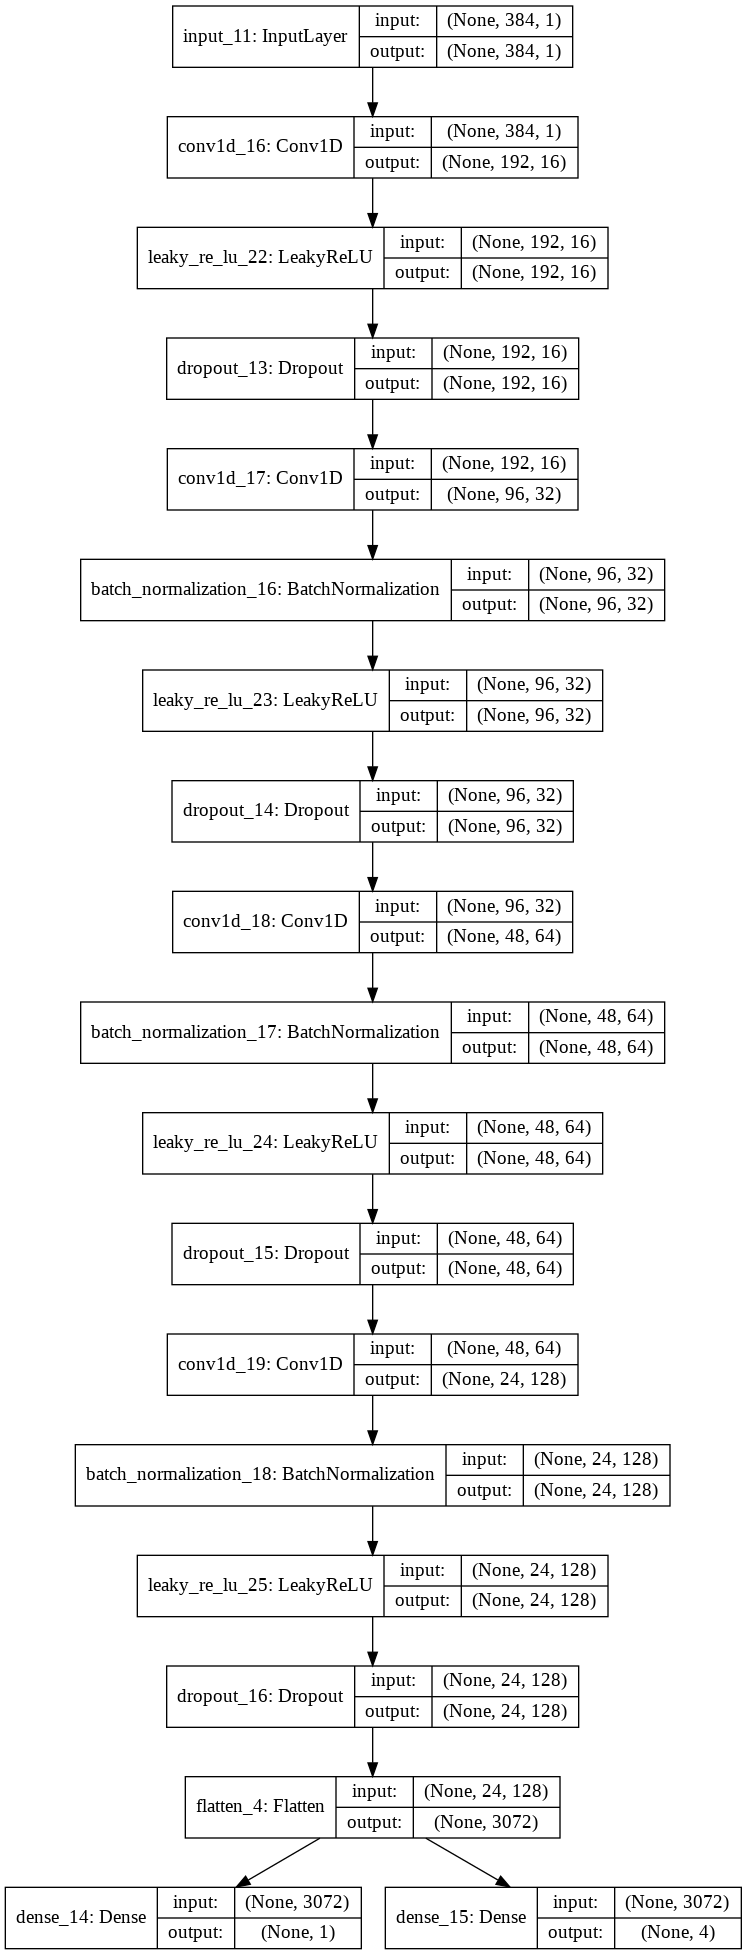

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(384,1), n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv1D(16, 3, strides=2, padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    # normal
    fe = Conv1D(32, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    # downsample to 7x7
    fe = Conv1D(64, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    #downsample one more
    fe = Conv1D(128, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
   
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    model.summary()
    return model

discriminator_model=define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file='discriminator_plot.png',show_shapes=True, show_layer_names=True)


### Generator

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 3072)         310272      input_10[0][0]                   
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        200         input_9[0][0]                    
____________________________________________________________________________________________

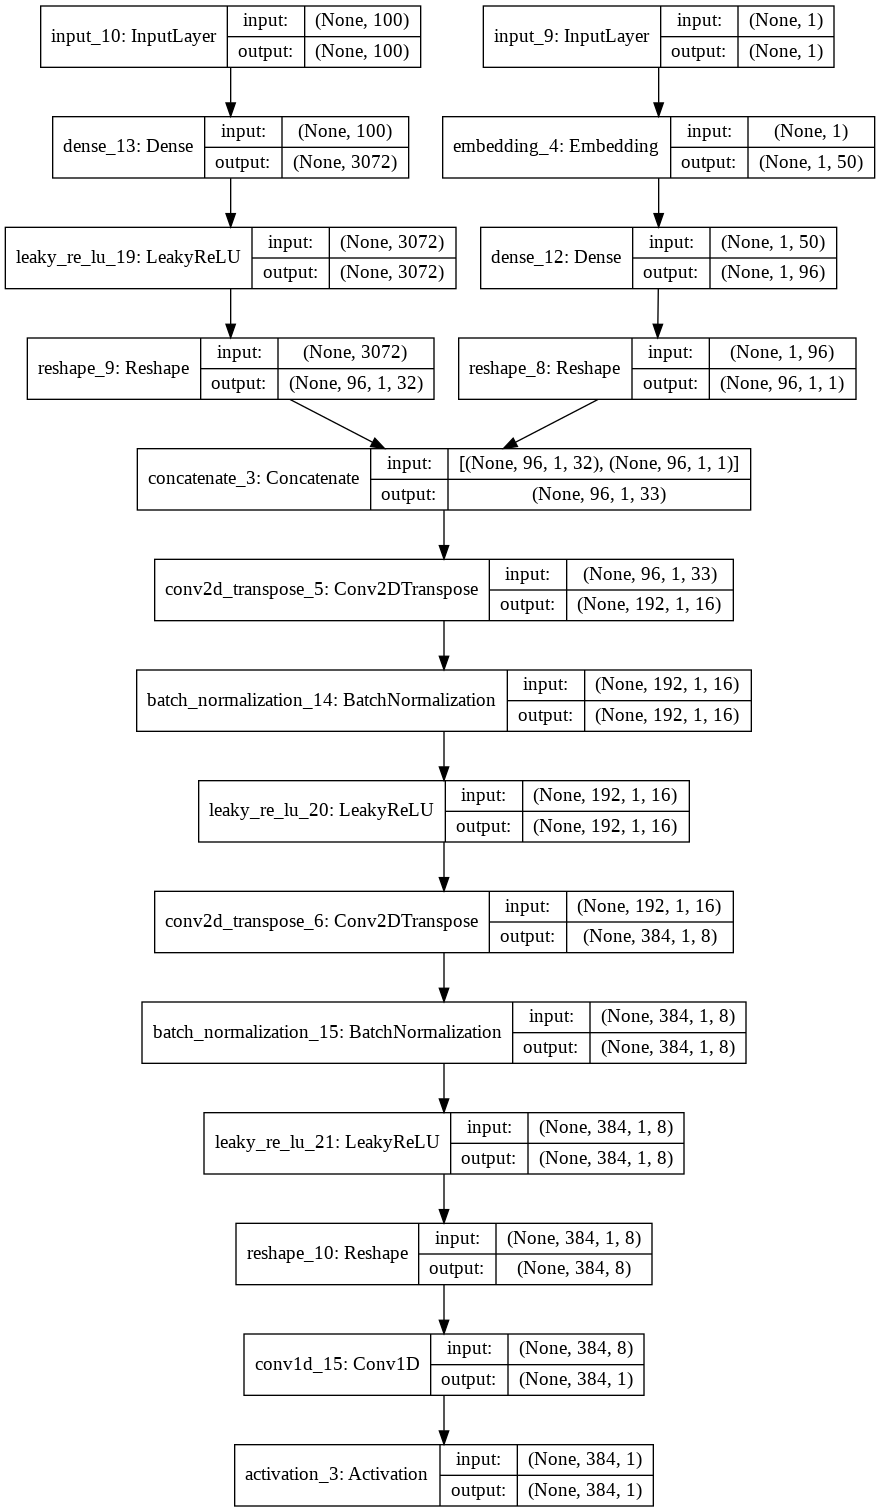

In [0]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    depth = 32 #32
    ks = 3
    dropout = 0.25
    dim = 96 #
    # 
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 96 * 1
    li = Dense(n_nodes)(li)
    
    # reshape to additional channel
    li = Reshape((96, 1, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = dim*depth
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((dim, 1, depth))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li]) #gen=96,1,32 x li=96,1,1
    # upsample to 192,1,16
    gen = Conv2DTranspose(16, 3, strides=(2,1), padding='same')(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #upsample to  384,1,8
    gen = Conv2DTranspose(8, 3, strides=(2,1), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #updamsple
    #gen = Conv2DTranspose(48, (3,3), strides=(2,1), padding='same', kernel_initializer=init)(gen)
    #gen = BatchNormalization()(gen)
    #gen = Activation('relu')(gen)
    #384 x 1 property image
    gen = Reshape((384,-1))(gen)
    # upsample to 28x28
    #gen = Conv1DTranspose(1, 3, padding='same', kernel_initializer=init)(gen)
    gen = Conv1D(1, 3, strides=1, padding='same')(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    model.summary()
    return model

#nastavit podla?

latent_dim=100

generator_model=define_generator(latent_dim, n_classes=4)
generator_model.summary()
plot_model(generator_model, to_file='generator_plot.png',show_shapes=True, show_layer_names=True)

### GAN

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 3072)         310272      input_10[0][0]                   
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        200         input_9[0][0]                    
____________________________________________________________________________________________

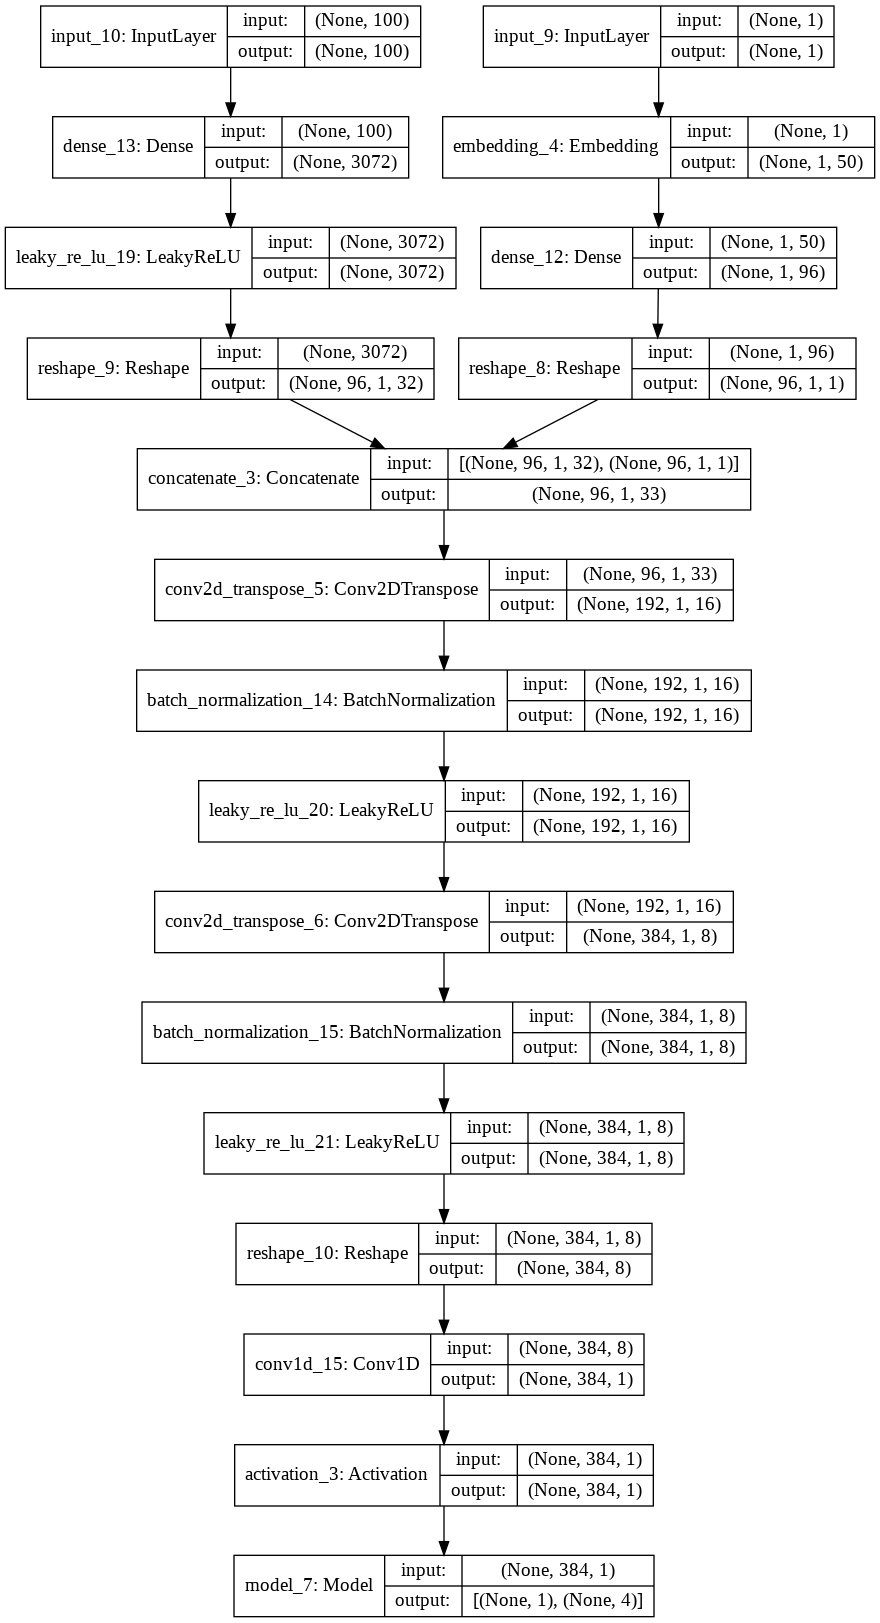

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model,d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

gan_model=define_gan(generator_model,discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png',show_shapes=True, show_layer_names=True)

##**InfoGAN** (tensorflow)

A tensorflow implementation of GAN ( exactly InfoGAN or Info GAN ) to one dimensional ( 1D ) time series data. We've applied InfoGAN model to one dimensional time series data for classifying time series data through unsupervised way.

**GitHub :**

https://github.com/buriburisuri/timeseries_gan

**Publication :**

https://arxiv.org/abs/1606.03657

InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets

**Nechápem ten jeho csv, akoze time_series bude asi cas, series1 a series2 nechapem. On akoze porovnava dva signaly alebo co???**

In [0]:
# -*- coding: utf-8 -*-
import sugartensor as tf
import numpy as np


__author__ = 'njkim@jamonglab.com'


class TimeSeriesData(object):

    def __init__(self, batch_size=128):

        # load data
        x = np.genfromtxt('asset/data/sample.csv', delimiter=',', dtype=np.float32)
        x = x[1:, 1:]

        window = 384  # window size
        max = 3000  # max value

        # delete zero pad data
        n = ((np.where(np.any(x, axis=1))[0][-1] + 1) // window) * window

        # normalize data between 0 and 1
        x = x[:n] / max

        # make to matrix
        X = np.asarray([x[i:i+window] for i in range(n-window)])
        # shuffle data
        np.random.shuffle(X)
        X = np.expand_dims(X, axis=2)

        # save to member variable
        self.batch_size = batch_size
        self.X = tf.sg_data._data_to_tensor([X], batch_size, name='train')
        self.num_batch = X.shape[0] // batch_size


        self.X = tf.to_float(self.X)


# set log level to debug
tf.sg_verbosity(10)

#
# hyper parameters
#

batch_size = 32   # batch size
num_category = 10  # category variable number
num_cont = 2   # continuous variable number
num_dim = 30   # total latent dimension ( category + continuous + noise )

#
# inputs
#

# input tensor ( with QueueRunner )
data = TimeSeriesData(batch_size=batch_size)
x = data.X

# generator labels ( all ones )
y = tf.ones(batch_size, dtype=tf.sg_floatx)

# discriminator labels ( half 1s, half 0s )
y_disc = tf.concat([y, y * 0], 0)


#
# create generator
#

# random class number
z_cat = tf.multinomial(tf.ones((batch_size, num_category), dtype=tf.sg_floatx) / num_category, 1).sg_squeeze()

# random seed = random categorical variable + random uniform
z = z_cat.sg_one_hot(depth=num_category).sg_concat(target=tf.random_uniform((batch_size, num_dim-num_category)))

# random continuous variable
z_cont = z[:, num_category:num_category+num_cont]

# generator network
with tf.sg_context(name='generator', size=(4, 1), stride=(2, 1), act='relu', bn=True):
    gen = (z.sg_dense(dim=1024)
           .sg_dense(dim=48*1*128)
           .sg_reshape(shape=(-1, 48, 1, 128))
           .sg_upconv(dim=64)
           .sg_upconv(dim=32)
           .sg_upconv(dim=2, act='sigmoid', bn=False))

#
# create discriminator & recognizer
#
print x
print  gen
# create real + fake image input
xx = tf.concat([x, gen], 0)

with tf.sg_context(name='discriminator', size=(4, 1), stride=(2, 1), act='leaky_relu'):
    # shared part
    shared = (xx.sg_conv(dim=32)
              .sg_conv(dim=64)
              .sg_conv(dim=128)
              .sg_flatten()
              .sg_dense(dim=1024))
    # shared recognizer part
    recog_shared = shared[batch_size:, :].sg_dense(dim=128)
    # discriminator end
    disc = shared.sg_dense(dim=1, act='linear').sg_squeeze()
    # categorical recognizer end
    recog_cat = recog_shared.sg_dense(dim=num_category, act='linear')
    # continuous recognizer end
    recog_cont = recog_shared.sg_dense(dim=num_cont, act='sigmoid')

#
# loss and train ops
#

loss_disc = tf.reduce_mean(disc.sg_bce(target=y_disc))  # discriminator loss
loss_gen = tf.reduce_mean(disc.sg_reuse(input=gen).sg_bce(target=y))  # generator loss
loss_recog = tf.reduce_mean(recog_cat.sg_ce(target=z_cat)) \
             + tf.reduce_mean(recog_cont.sg_mse(target=z_cont))  # recognizer loss

train_disc = tf.sg_optim(loss_disc + loss_recog, lr=0.0001, category='discriminator')  # discriminator train ops
train_gen = tf.sg_optim(loss_gen + loss_recog, lr=0.001, category='generator')  # generator train ops


#
# training
#

# def alternate training func
@tf.sg_train_func
def alt_train(sess, opt):
    l_disc = sess.run([loss_disc, train_disc])[0]  # training discriminator
    l_gen = sess.run([loss_gen, train_gen])[0]  # training generator
    return np.mean(l_disc) + np.mean(l_gen)


# do training
alt_train(log_interval=10, max_ep=100, ep_size=data.num_batch, early_stop=False)



##**GAN that creates short audio clips**

**GitHub :**

https://github.com/djl12328/SignalGeneration

**Publication :** None


In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling1D, Conv1D, UpSampling2D, MaxPooling1D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import wave
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import argparse

from tqdm import tqdm

class BatchGenerator():
    def __init__(self, batch_size, directory):
        self.MAX_SIZE = int.from_bytes(b"\xFF\xFF", "little")
        
        self.batch_size = batch_size
        self.directory = directory

        self.data = self._load_data()


    def fetch_random_batch(self):
        np.random.shuffle(self.data)

        return self.data[0:self.batch_size]
    
    def _convert_bytes_to_tensor(self, byte_list):
        four_wide = [(byte_list[i*4:i*4+2], byte_list[i*4+2:i*4+4]) for i in range(len(byte_list) // 4)]

        channel1_list = [int.from_bytes(four_wide[i][0], "little") / self.MAX_SIZE for i in range(len(four_wide))]
        channel2_list = [int.from_bytes(four_wide[i][1], "little") / self.MAX_SIZE for i in range(len(four_wide))]
        
        signal_tensor = np.column_stack([channel1_list, channel2_list])

        return signal_tensor
    
    def convert_tensor_to_bytes(self, tensor):
        tensor *= self.MAX_SIZE
        tensor = tensor.astype(np.int16)

        byte_list = tensor.tobytes()

        return byte_list

    def _load_data(self):
        data = []

        first = True
        for file in tqdm(os.listdir(self.directory)):
            if file.endswith(".wav"):
                wave_reader = wave.open(self.directory + file, "rb")

                if first:
                    self.channels = wave_reader.getnchannels()
                    self.sampwidth = wave_reader.getsampwidth()
                    self.framerate = wave_reader.getframerate()
                    self.frames_per_sample = wave_reader.getnframes()
                    first = False

                byte_list = wave_reader.readframes(wave_reader.getnframes())
                sample_tensor = self._convert_bytes_to_tensor(byte_list)

                data.append(sample_tensor)
        
        return np.asarray(data)
    
    def save_bytes_to_wav(self, byte_list, filename):
        wave_writer = wave.open(filename, "wb")

        wave_writer.setnchannels(self.channels)
        wave_writer.setsampwidth(self.sampwidth)
        wave_writer.setframerate(self.framerate)
        wave_writer.writeframes(byte_list)

        wave_writer.close()

class DCGAN():
    def __init__(self, inputdir, outputdir, batch_size, interval, modelfile=None):
        # Set up batch generator
        self.bg = BatchGenerator(batch_size, inputdir)
        self.batch_size = batch_size
        self.inputdir = inputdir
        self.outputdir = outputdir
        self.interval = interval
        self.modelfile = modelfile

        # Input shape
        self.sample_frames = 441000
        self.channels = 2
        self.sample_shape = (self.sample_frames, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        print("Discriminator built")
        # Build the generator
        self.generator = self.build_generator()
        print("Generator built")
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        

    def build_generator(self):

        model = Sequential()
        model.add(Dense(1 * 11025, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((11025, 1)))
        model.add(Conv1D(256, kernel_size=7, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Reshape((11025, 1, 256)))
        model.add(UpSampling2D(size=(5, 1)))
        model.add(Reshape((55125, 256)))
        model.add(Conv1D(128, kernel_size=7, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Reshape((55125, 1, 128)))
        model.add(UpSampling2D(size=(2, 1)))
        model.add(Reshape((110250, 128)))
        model.add(Conv1D(128, kernel_size=7, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Reshape((110250, 1, 128)))
        model.add(UpSampling2D(size=(2, 1)))
        model.add(Reshape((220500, 128)))
        model.add(Conv1D(64, kernel_size=7, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Reshape((220500, 1, 64)))
        model.add(UpSampling2D(size=(2, 1)))
        model.add(Reshape((441000, 64)))
        model.add(Conv1D(32, kernel_size=7, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv1D(self.channels, kernel_size=7, padding="same"))
        model.add(Activation("sigmoid"))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv1D(32, kernel_size=3, strides=2, input_shape=self.sample_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv1D(64, kernel_size=3, strides=2, padding="same"))
        #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv1D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv1D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(MaxPooling1D(pool_size=2, padding="valid"))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.sample_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs):

        #self.bg.data = np.expand_dims(self.bg.data, axis=3)

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------


            batch = self.bg.fetch_random_batch()

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
            gen_samples = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(batch, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_samples, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % self.interval == 0:
                self.save_samples(epoch)

    def save_samples(self, epoch):
        n = 5
        noise = np.random.normal(0, 1, (n, self.latent_dim))
        gen_samples = self.generator.predict(noise)

        for i in range(n):
            tensor = gen_samples[i]
            byte_list = self.bg.convert_tensor_to_bytes(tensor)
            path = self.outputdir + "sample{}".format(epoch) + "_{}.wav".format(i)
            self.bg.save_bytes_to_wav(byte_list, path)

def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("inputdir", help="Directory containing audio samples")
    parser.add_argument("outputdir", help="Directory to output samples during training")
    parser.add_argument("--batchsize", type=int, default=8, help="Batch size used during training")
    parser.add_argument("--interval", type=int, default=10, help="Interval between saving samples during training")
    parser.add_argument("--modelfile", help="File to save model at after training")
    parser.add_argument("--epochs", type=int, default=1000, help="Number of training epochs")

    args = parser.parse_args()

    gan = DCGAN(args.inputdir, args.outputdir, args.batchsize, args.interval, args.modelfile)
    gan.train(args.epochs)

if __name__ == '__main__':
    main()





##**Simple GAN in Keras** (image not signal)

https://pathmind.com/wiki/generative-adversarial-network-gan

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, save_interval=200)

NameError: ignored

## **GAN_Time_Series** (tensorflow, hard)

A model to generate time series data with the purpose of augmenting a dataset of various time series.

The model is a Conditional Generative Adversarial Network for time series with not regular time intervals.

The model is created to generate a new time series given a training set of them.

**GitHub :**

https://github.com/gioramponi/GAN_Time_Series

**Publication :**

https://arxiv.org/abs/1811.08295